## Problem statement

Encrypted data provided for US stocks. Stock ticker and time periods are anonymized.

Price features: Adjusted OHLC price, Volume

Options: Implied volatility for different expiry dates and delta, Put/Call Volume and Open Interest

Universe: ETF for US equity, bonds and commodities. (column id in the training csv file)

## Goal

Predict Next 20-days log-return (column target_20 in the training csv file)

Models can predict the direction of return and return an action (-1,0,1)

1 means the model will buy and hold the stock for the next 20 days

0 means the model will do nothing

-1 means the model will sell the stock and cover in 20 days

Models can also assign a weight between -1 to 1 as a portfolio holding instead.

## Evaluation criteria:
The portfolio return is calculated as the sum of return for each asset

We then score the model using the sharpe ratio of the daily returns over a test period of 2 years

## Data sources:
WRDS data: US EOD price and US EOD options

Train period: 2006-2015
Validation period: 2016-2017
Test period: 2018-2019
Note: In the training data, some of the ETFs will have limited or no data in the train period because these ETFs are only launched after 2015. Consider how to use the features of other ETFs to learn patterns that can be generalised, or set the weights of these assets to be zero.

## Submission
In the example notebook, we provide two functions which allows you to generate predictions for the validation (Public Leaderboard) and test (Private Leaderboard) datasets. It will generate around 20k predictions each so it will takes time to run. You should them submit the csv predictions with filename the format {your_team_name}_validation_prediction.csv and {your_team_name}_test_prediction.csv. Submit your validation and test predictions [here](https://forms.gle/PSg54dMwZjia1HoYA).

---

## Alternative problem statement:
Predict US ETFs returns using price and implied volatility features. 

Predict a weighting between -1 to 1 for each asset at each timestamp

Optimise for out-of-sample Sharpe ratio

---
## Latest problem statement:
For the prediction challenge, you should create a model which predicts the forward returns

If you think the return is positive then assign a weight of +1

If you think the return is negative then assign a weight of -1

If you are not sure then assign a weight of 0

In [ ]:
!pip install --index-url https://test.pypi.org/simple/ --no-deps --upgrade --force-reinstall algothon2021
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import random

plt.style.use("fivethirtyeight")

pd.set_option('display.max_rows', 178)

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 74.6MB 80kB/s 
  Found existing installation: algothon2021 0.0.6
    Uninstalling algothon2021-0.0.6:
      Successfully uninstalled algothon2021-0.0.6
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "drive/My Drive/Algothon2021/algothon_2021"
df = pd.read_csv(f"{path}/prediction_train_with_targets.csv")

# Exploratory Data Analysis
+ No missing data
+ High dimensional; 177 predictors
+ `y` looks leptokurtic


> Don't try predicting a weighting for each asset at each timestamp since the number of data points for each asset is different (timestamps are also ambiguous).



In [ ]:
display(df.describe())
# no missing columns
print(df.columns[df.count() != df.shape[0]])

,IV_30.0_-75.0_mean_50,IV_30.0_-50.0_sd_50,optionvolume_ratio_sd_10,put_call_OI_sd_25,adjclose_mean_10,IV_30.0_-75.0,high_close_mean_50,logreturn_sd_50,optionvolume_ratio_sd_5,adjclose_mean_5,open_close_sd_10,IV_30.0_-50.0_sd_10,dollarvolume_ratio_sd_100,high_close_sd_10,logreturn_mean_10,optionOI_ratio_mean_5,IV_30.0_25.0_mean_25,IV_30.0_-25.0_mean_10,IV_30.0_25.0_sd_25,open_close_mean_50,put_call_volume_sd_50,put_call_OI_sd_10,IV_30.0_-50.0_sd_5,high_close_mean_10,IV_30.0_50.0_mean_100,IV_30.0_-25.0_sd_5,adjclose_mean_25,optionvolume_ratio_sd_50,IV_30.0_-25.0,high_close_mean_100,put_call_volume_mean_100,open_close_sd_100,low_close,low_close_sd_5,IV_30.0_50.0_mean_10,optionOI_ratio_mean_100,IV_30.0_-50.0_mean_50,put_call_OI_sd_50,logreturn,put_call_volume_mean_25,...,IV_30.0_50.0_sd_100,IV_30.0_-25.0_mean_50,IV_30.0_50.0,dollarvolume_ratio_sd_10,adjclose_sd_10,put_call_volume_mean_50,adjclose_mean_100,IV_30.0_25.0,open_close,put_call_volume_sd_100,IV_30.0_-50.0_mean_10,high_close_sd_5,IV_30.0_75.0_mean_5,high_close,dollarvolume_ratio_mean_100,optionOI_ratio_sd_100,open_close_sd_5,adjclose_sd_50,optionOI_ratio_sd_25,high_close_mean_25,low_close_sd_100,IV_30.0_-75.0_mean_25,IV_30.0_50.0_mean_25,adjclose,dollarvolume_ratio_mean_5,put_call_OI_mean_25,IV_30.0_75.0_sd_5,IV_30.0_-25.0_mean_100,optionvolume_ratio,optionvolume_ratio_sd_100,IV_30.0_75.0_mean_10,dollarvolume_ratio_mean_50,low_close_mean_25,low_close_mean_10,put_call_OI_sd_100,optionOI_ratio_mean_25,IV_30.0_50.0_mean_50,open_close_sd_25,high_close_mean_5,target_20
count,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,...,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000,33827.000000
mean,0.244966,0.029735,3.562121,0.256143,78.600356,0.243942,1.008713,0.013964,3.040072,78.658013,0.011061,0.016808,0.604551,0.007389,0.000207,1.004334,0.213039,0.266566,0.021030,1.000255,8.218448,0.157167,0.013278,1.008653,0.228447,0.013865,78.433832,4.797743,0.266283,1.008797,3.570538,0.011827,0.990894,0.006610,0.226205,1.004724,0.239788,0.359697,0.000198,3.518774,...,0.038530,0.267917,0.225955,0.534081,1.108418,3.519518,77.599911,0.212407,1.000266,9.884146,0.238537,0.006910,0.254728,1.008649,1.119457,0.073496,0.010703,2.336404,0.067495,1.008672,0.008308,0.244388,0.226662,78.704456,1.114717,1.915121,0.024255,0.269008,2.327815,5.292059,0.254890,1.117623,0.990848,0.990874,0.488798,1.004343,0.227416,0.011320,1.008646,0.003968
std,0.128041,0.024608,10.424751,0.662327,52.220088,0.142857,0.006978,0.009653,10.708950,52.283002,0.008533,0.015108,0.448253,0.021890,0.004763,0.032877,0.121971,0.140669,0.017783,0.001955,25.402784,0.479334,0.013338,0.009771,0.122321,0.014247,52.046603,9.809762,0.142415,0.006279,4.659760,0.007673,0.012798,0.009472,0.128569,0.006507,0.126983,0.864482,0.016809,6.963110,...,0.030808,0.136768,0.130418,0.422607,0.988625,5.610557,51.181070,0.124681,0.013896,25.324543,0.129933,0.022036,0.141161,0.024012,0.079253,0.030093,0.009158,1.982566,0.039567,0.007835,0.008298,0.130765,0.127405,52.337322,0.226868,2.557009,0.024676,0.132059,11.144651,9.449450,0.140116,0.093192,0.00

Index([], dtype='object')


In [ ]:
print("Number of assets: ", df['id'].nunique(), "\n") #We have some data for 27 assets
df['id'].value_counts() #Assets 26, 16, 15, 13, 2 have severely limited training data

#Presumably, each row is data from one day. 
#There are 253 trading days in a year, 1903/253 = 7.52 years. But train period 
#is from 2006-2015? 
#Perhaps many rows were dropped due to missing or erroneous data.

Number of assets:  27 



-1.151292    1903
-0.601893    1803
-0.837350    1803
-1.700691    1803
 0.732361    1802
 0.339933    1802
 0.810846    1799
 0.182962    1797
 0.418419    1787
 1.203274    1722
 0.967817    1565
 1.360245    1553
 0.496904    1517
 0.889332    1363
 1.281760    1311
-1.543720    1249
 0.653875    1180
 0.575390    1156
-1.622205    1135
-1.072807    1046
-1.229778     859
-0.287951     709
-1.779176     333
-0.915836     332
-0.758864     319
-0.680379     160
 0.104476      19
Name: id, dtype: int64

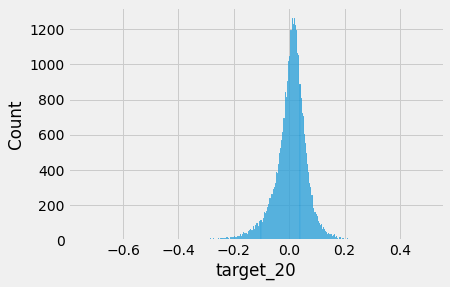

In [ ]:
sns.histplot(y)

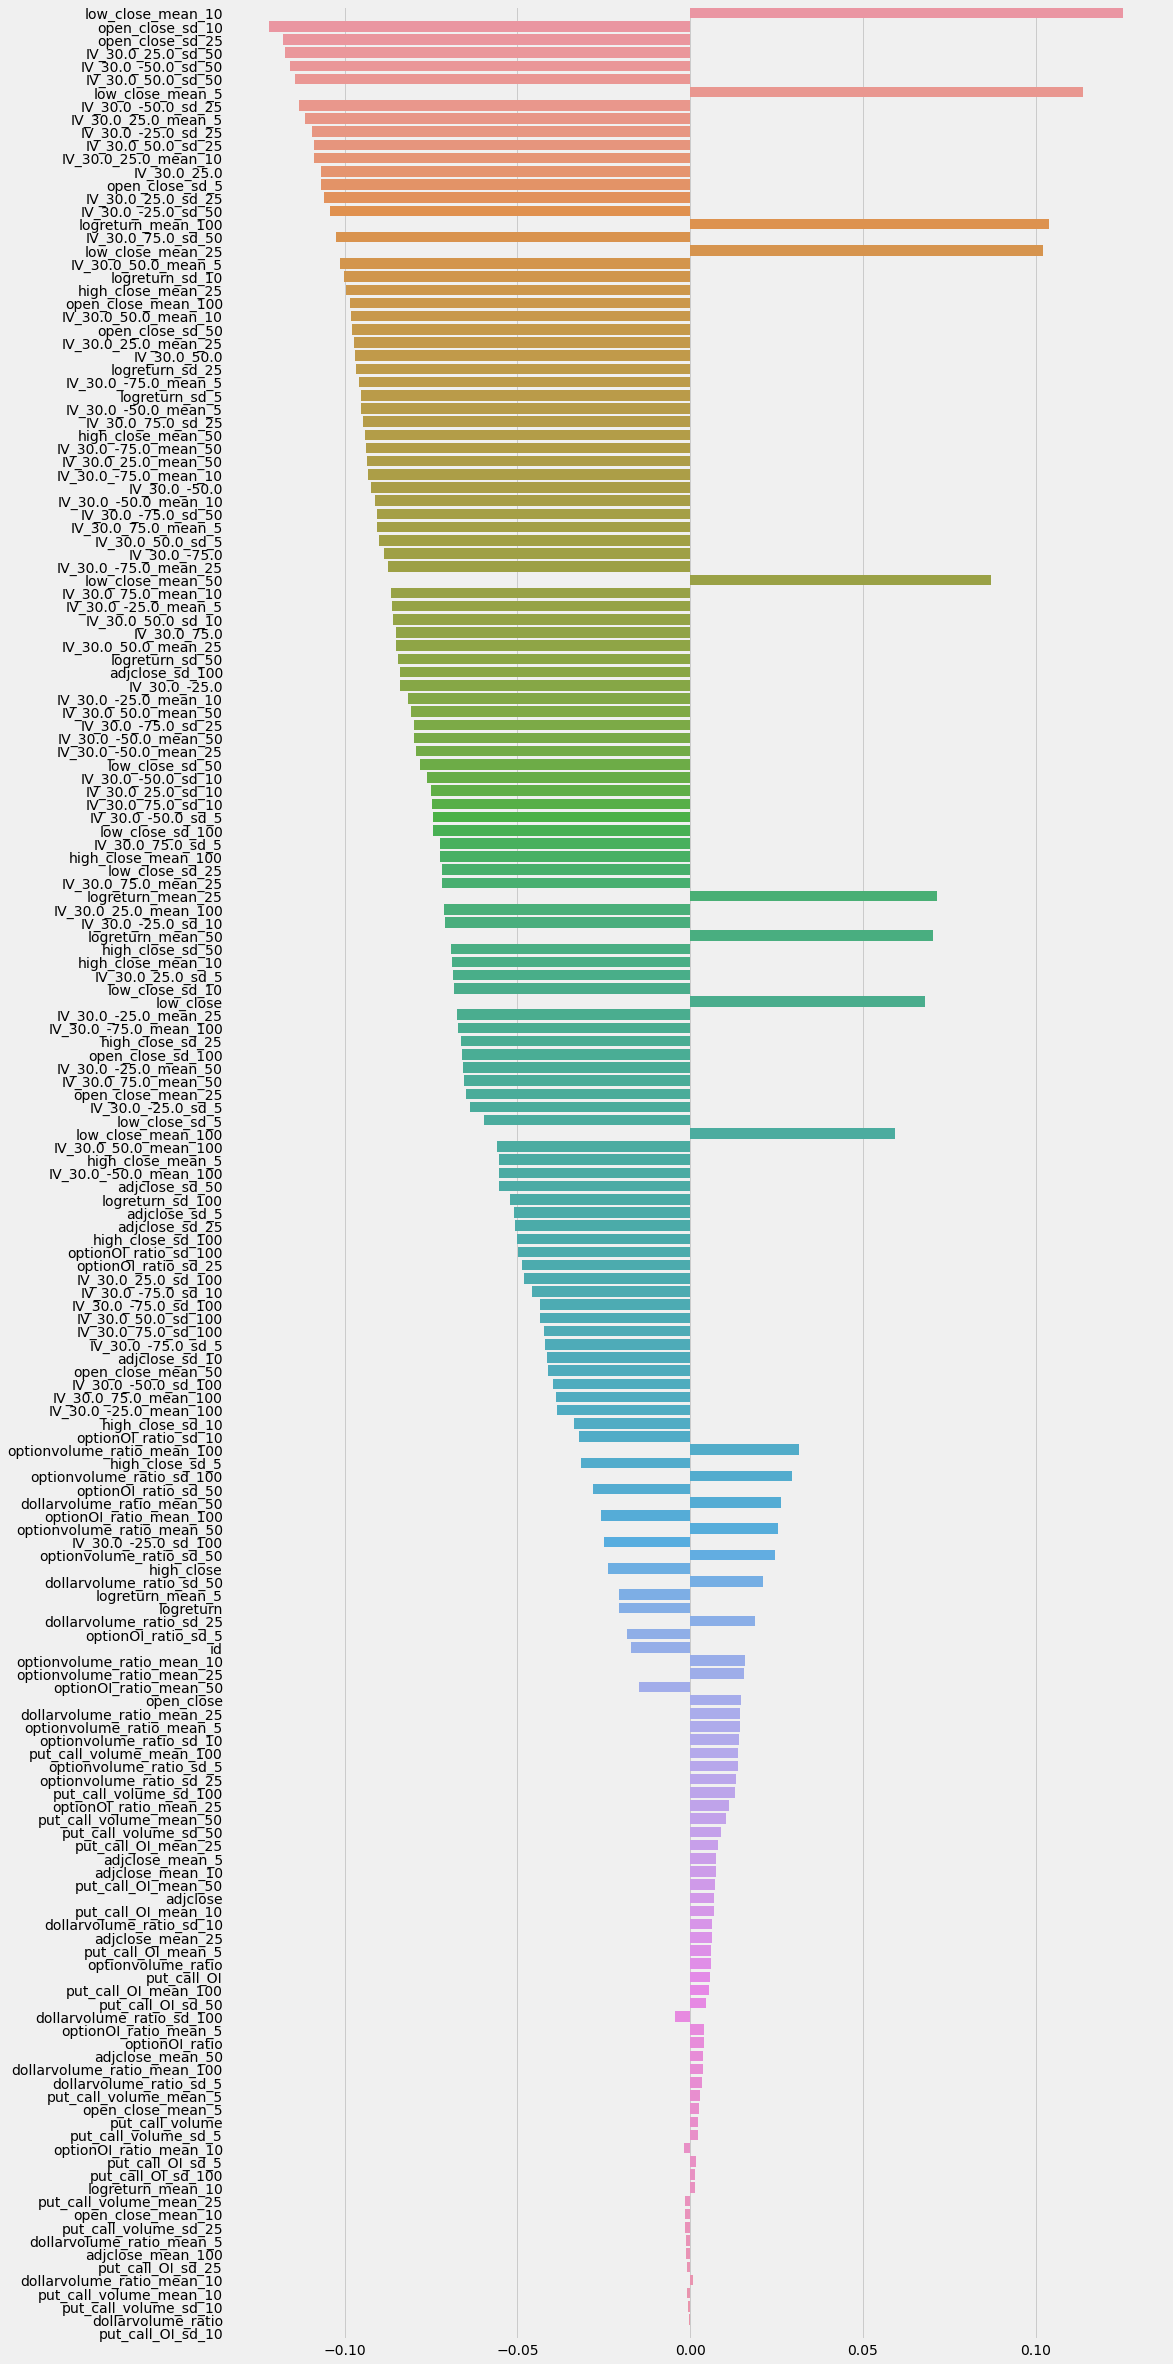

In [ ]:
corrs = X.corrwith(y)
x_plot, y_plot = zip(*sorted(zip(corrs.index, corrs.values), key = lambda x:abs(x[1])))
fig, ax = plt.subplots(figsize=(15, 40))
sns.barplot(y=list(x_plot)[::-1], x=list(y_plot)[::-1])

## Define a baseline performance

In [ ]:
def write_backtest(results, description, threshold,  params,
                   train_preds, val_preds, test_preds, 
                   y_train, y_val, y_test):
  strat = [-sharpe_loss(x[1],  x[0]).numpy() for x in zip([train_preds, val_preds, test_preds],[y_train, y_val, y_test])]
  strat += [np.mean((x[1] > 0) == (x[0] > threshold)) for x in zip([train_preds, val_preds, test_preds],[y_train, y_val, y_test])]
  strat = pd.DataFrame([strat + [description, str(params)]])
  strat.columns =  ['train_sharpe','val_sharpe','test_sharpe','train_acc','val_acc','test_acc', 'description', 'params']
  results = pd.concat([results, strat], axis = 0)
  results = results.drop_duplicates().reset_index(drop=True)
  results.to_csv("drive/MyDrive/Algothon2021/prediction-backtest-log.csv", index=False)
  return results

try:
  results = pd.read_csv("drive/MyDrive/Algothon2021/prediction-backtest-log.csv")
except:
  # long only, assume all signals are 1
  long_only = [-sharpe_loss(np.ones(temp.shape[0]),  temp).numpy() for temp in [y_train, y_val, y_test]]
  long_only += [np.mean(np.ones(temp.shape[0]) == (temp > 0)) for temp in [y_train, y_val, y_test]]
  long_only += ['Long Only']
  results = pd.DataFrame([long_only], columns = ['train_sharpe','val_sharpe','test_sharpe',
                                                 'train_acc','val_acc','test_acc', 'description'])

# Neural Network approach

We train a neural network to directly optimise for Sharpe  by setting batch sharpe as a loss function

In [ ]:
#Split training set to evaluate model
X, y = df.drop(columns=['target_20']), df['target_20']

train_fraction = 0.6
test_fraction = 0.2
train_end, val_end = int(X.shape[0] * train_fraction), int(X.shape[0] * (train_fraction + test_fraction))

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

sharpe = lambda x: np.mean(x / np.std(x))

(20296, 177) (20296,)
(6765, 177) (6765,)
(6766, 177) (6766,)


Pre-checks

In [ ]:
model.predict(np.zeros((1, X.shape[1])))

array([[0.]], dtype=float32)

Modelling
+ Classification
+ Regression
+ train a model to directly optimise Batch Sharpe

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop


def sharpe_loss(y_true, y_pred):
  ret = tf.math.multiply(y_pred, y_true)
  # minimise negative sharpe i.e. maximise sharpe
  return -tf.reduce_mean(ret / tf.math.reduce_std(ret))

def SharpeCVar(batch_size, a):
  k = int(a * batch_size)
  def sharpe_cvar_loss(y_true, y_pred):
    ret = tf.math.multiply(y_pred, y_true)
    # minimise negative sharpe i.e. maximise sharpe
    top, idx = tf.math.top_k(-ret)
    return -tf.reduce_mean(ret / tf.math.reduce_std(ret)) + 0.5 * tf.reduce_mean(top) / tf.math.reduce_std(ret)
  return sharpe_cvar_loss

# set a random seed in case we want to reproduce model
SEED = random.randint(0, 999999)
print("SEED",SEED)
tf.random.set_seed(SEED)

params = {"activation":"tanh",
          "optimizer":"Rmsprop",
          "initializer":"GlorotUniform",
          "l1_weight_penalty":1e-6,
          "l2_weight_penalty":1e-4,
          "EPOCHS":100,
          "BATCH_SIZE":1024,
          "lr": 0.1,
          "layers":1,
          "seed":SEED,
          "EarlyStoppingPatience":20,
          "loss":"SharpeCVaR",
          "alpha": 0.01
          }
alpha = 0.01
sharpe_cvar = SharpeCVar(params["BATCH_SIZE"], params["alpha"])
losses = {"sharpe": sharpe_loss, "binary_crossentropy":"binary_crossentropy", 
          "SharpeCVaR":sharpe_cvar}

input = Input(X.shape[1],)
b_norm = BatchNormalization()(input)
output = Dense(1, activation=params["activation"], 
               kernel_initializer=tf.keras.initializers.GlorotUniform(SEED),
               kernel_regularizer=regularizers.l1_l2(l1=params["l1_weight_penalty"], 
                                                     l2=params["l2_weight_penalty"]),
               )(b_norm)
model = Model(input, output)
early_stopping = EarlyStopping(patience=params["EarlyStoppingPatience"],restore_best_weights=True)

rms_prop = RMSprop(learning_rate=params["lr"])

model.compile(loss=losses[params["loss"]], optimizer=rms_prop)
model.summary()


model.fit(X_train, y_train, validation_data=(X_val, y_val), 
          epochs=params["EPOCHS"], 
          batch_size=params["BATCH_SIZE"], 
          shuffle=False,  callbacks=[early_stopping])

SEED 892867
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 177)]             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 177)               708       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 178       
Total params: 886
Trainable params: 532
Non-trainable params: 354
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 1s 23ms/step - loss: -0.1108 - val_loss: -0.1404
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: -0.1687 - val_loss: -0.1399
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: -0.1655 - val_loss: -0.1396
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss:

## NN Preds

In [ ]:
test_preds = model.predict(X_test, batch_size=params["BATCH_SIZE"]).reshape(-1)
train_preds = model.predict(X_train, batch_size=params["BATCH_SIZE"]).reshape(-1)
val_preds = model.predict(X_val,batch_size=params["BATCH_SIZE"]).reshape(-1)
threshold = 0
description = "Keras EarlyStopping, BatchNorm trained on Sharpe"
results = write_backtest(results, description, threshold,  params,
                   train_preds, val_preds, test_preds, 
                   y_train, y_val, y_test)
display(results)

,train_sharpe,val_sharpe,test_sharpe,train_acc,val_acc,test_acc,description,params
0,0.085949,0.044679,0.018951,0.610071,0.614043,0.583506,Long Only,NaN
1,0.126503,0.140221,0.129252,0.619334,0.634442,0.599911,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
2,0.160302,0.133544,0.078507,0.626084,0.631042,0.594147,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
3,0.132056,0.109335,0.018589,0.599084,0.627347,0.583358,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
4,0.117935,0.146046,0.073255,0.614801,0.635033,0.578628,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
5,0.160339,0.118955,0.065691,0.624015,0.626903,0.590304,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
6,0.131539,0.084518,0.015281,0.563658,0.623503,0.581289,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'sigmoid', 'optimizer': 'Rmspro..."
7,0.087607,0.051747,0.027314,0.610071,0.614043,0.583506,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'sigmoid', 'optimizer': 'Rmspro..."
8,0.047677,-0.044773,-0.018951,0.522221,0.385514,0.416494,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
9,0.085949,0.044679,0.018951,0.610071,0.614043,0.583506,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."


# GBDT approach

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label = y_train > 0)
val_data = lgb.Dataset(X_val, label = y_val > 0)

SEED = random.randint(0, 999999)
print("SEED",SEED)
param = {"n_estimators":1000,
         'max_depth':10,'num_leaves': 64, "learning_rate":0.005,
         'objective': 'binary', "num_round":500, "verbose":-1, "seed":SEED}

evals_result = {} 
bst = lgb.train(param, train_data,valid_sets=[val_data], 
                early_stopping_rounds=20,evals_result=evals_result)

SEED 491707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.666514
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.666057
[3]	valid_0's binary_logloss: 0.665705
[4]	valid_0's binary_logloss: 0.665305
[5]	valid_0's binary_logloss: 0.664923
[6]	valid_0's binary_logloss: 0.66458
[7]	valid_0's binary_logloss: 0.664171
[8]	valid_0's binary_logloss: 0.664056
[9]	valid_0's binary_logloss: 0.663951
[10]	valid_0's binary_logloss: 0.663848
[11]	valid_0's binary_logloss: 0.663751
[12]	valid_0's binary_logloss: 0.663662
[13]	valid_0's binary_logloss: 0.663573
[14]	valid_0's binary_logloss: 0.663476
[15]	valid_0's binary_logloss: 0.663397
[16]	valid_0's binary_logloss: 0.66332
[17]	valid_0's binary_logloss: 0.663238
[18]	valid_0's binary_logloss: 0.663168
[19]	valid_0's binary_logloss: 0.663091
[20]	valid_0's binary_logloss: 0.663015
[21]	valid_0's binary_logloss: 0.662948
[22]	valid_0's binary_logloss: 0.662854
[23]	valid_0's binary_logloss: 0.662831
[24]	valid_0's binary_logloss

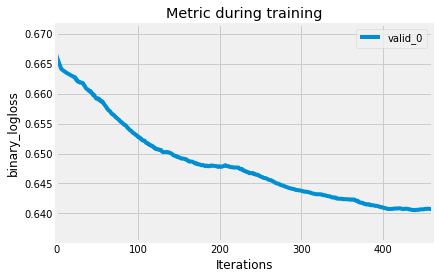

In [ ]:
lgb.plot_metric(evals_result)

## GBDT Preds

In [ ]:
train_preds = bst.predict(X_train)
val_preds = bst.predict(X_val)
test_preds = bst.predict(X_test)
threshold = 0.5
description = "LightGBM EarlyStopping patience 20"
results = write_backtest(results, description, threshold,  param,
                   train_preds, val_preds, test_preds, 
                   y_train, y_val, y_test)
display(results)

,train_sharpe,val_sharpe,test_sharpe,train_acc,val_acc,test_acc,description,params
0,0.085949,0.044679,0.018951,0.610071,0.614043,0.583506,Long Only,NaN
1,0.126503,0.140221,0.129252,0.619334,0.634442,0.599911,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
2,0.160302,0.133544,0.078507,0.626084,0.631042,0.594147,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
3,0.132056,0.109335,0.018589,0.599084,0.627347,0.583358,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
4,0.117935,0.146046,0.073255,0.614801,0.635033,0.578628,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
5,0.160339,0.118955,0.065691,0.624015,0.626903,0.590304,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
6,0.131539,0.084518,0.015281,0.563658,0.623503,0.581289,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'sigmoid', 'optimizer': 'Rmspro..."
7,0.087607,0.051747,0.027314,0.610071,0.614043,0.583506,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'sigmoid', 'optimizer': 'Rmspro..."
8,0.047677,-0.044773,-0.018951,0.522221,0.385514,0.416494,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."
9,0.085949,0.044679,0.018951,0.610071,0.614043,0.583506,"Keras EarlyStopping, BatchNorm trained on Sharpe","{'activation': 'tanh', 'optimizer': 'Rmsprop',..."


# Diagnosis

Inspect what the **models** are *doing*

## Model Output

train accuracy: 0.88382
val accuracy: 0.63725
test accuracy: 0.60996


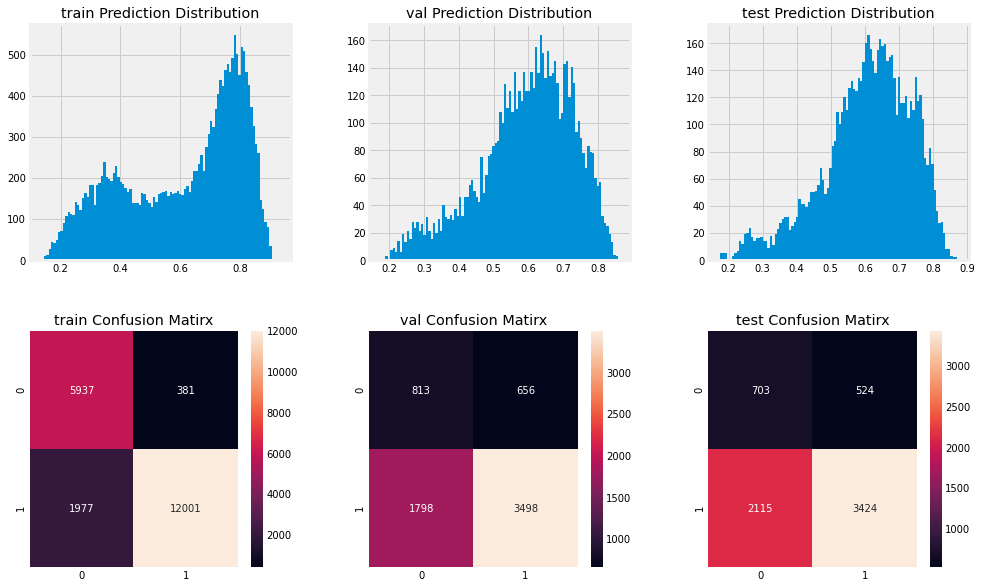

In [ ]:
from sklearn.metrics import confusion_matrix

def diagnosis(train_preds, val_preds, test_preds, y_train, y_val, y_test, threshold):
  fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows = 2)

  for i,x in enumerate([train_preds, val_preds, test_preds]):
    pd.DataFrame(x).hist(bins=100, ax=ax[0, i])

  titles = ["train", "val", "test"]
  for i, x in enumerate(titles):
    ax[0, i].set_title(f"{x} Prediction Distribution")
    ax[1, i].set_title(f"{x} Confusion Matirx")

  for i,x in enumerate(zip([train_preds, val_preds, test_preds],
                          [y_train, y_val, y_test])):
    sns.heatmap(confusion_matrix(x[0] > threshold, x[1] > 0), ax = ax[1, i], annot=True, fmt='g')
    print(f"{titles[i]} accuracy: {np.mean((x[0] > threshold) == (x[1] > 0)):.5f}")

diagnosis(train_preds, val_preds, test_preds, y_train, y_val, y_test, 0.5)


## NN Feature Importance (weights)

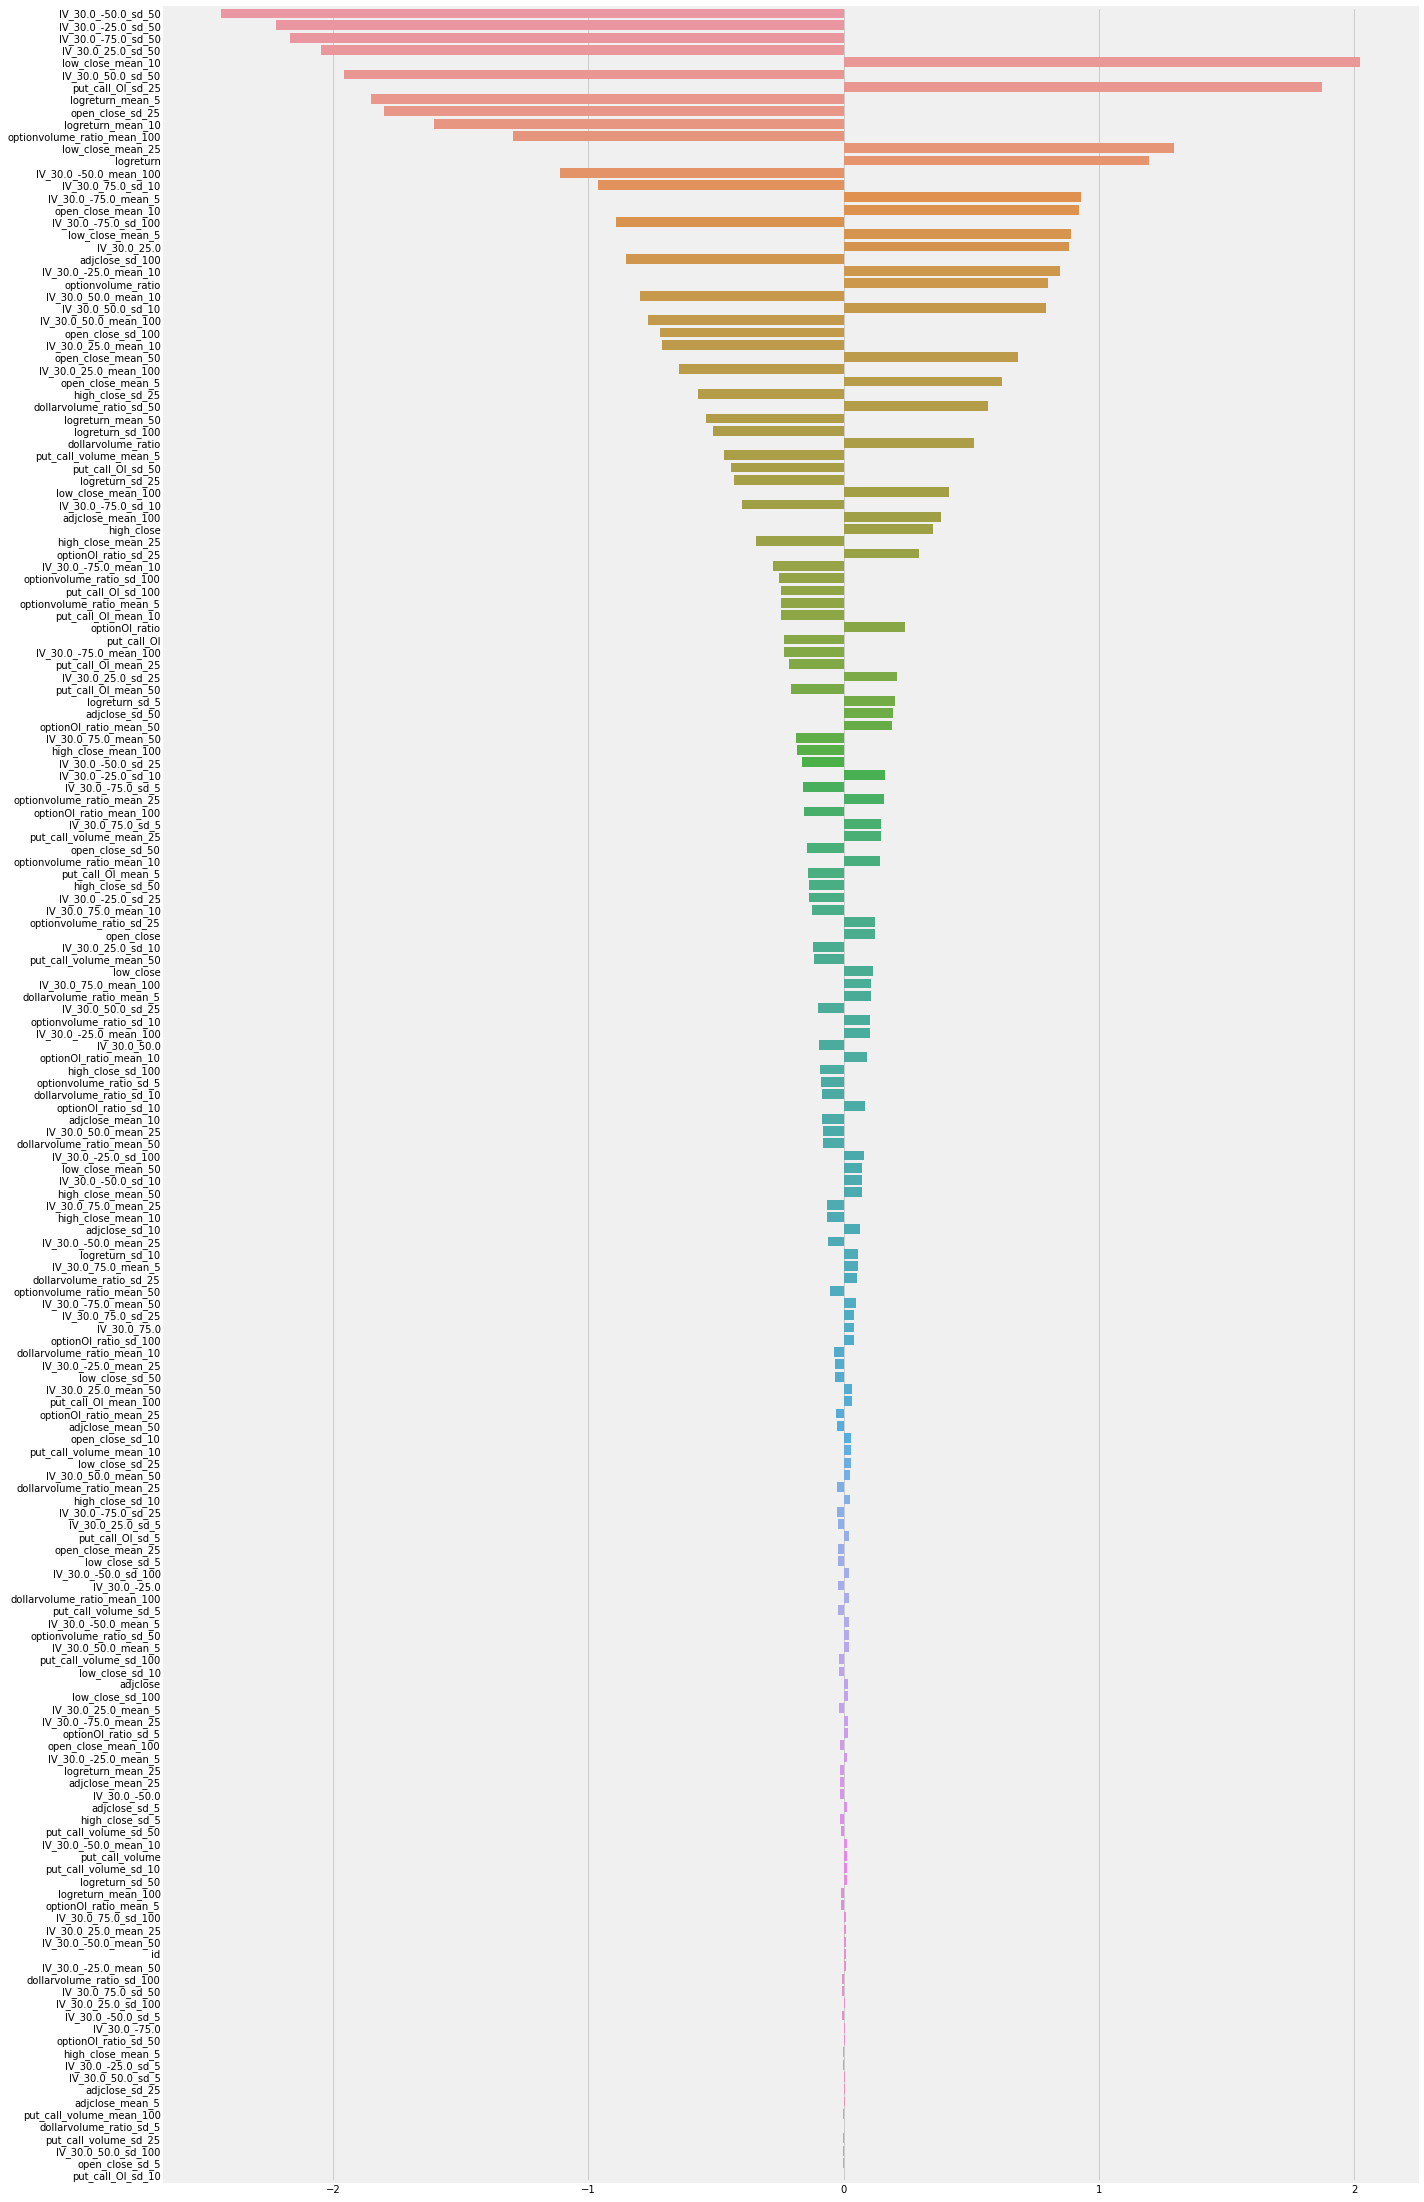

In [ ]:
weights = model.layers[2].get_weights()[0].reshape(-1)
importance_x, importance_y = zip(*sorted(zip(list(X.columns), weights), key = lambda k: abs(k[1])))
fig, ax = plt.subplots(figsize=(20, 40))
sns.barplot(y = list(importance_x)[::-1], x = list(importance_y)[::-1], ax= ax)

## LGB Feature Importance

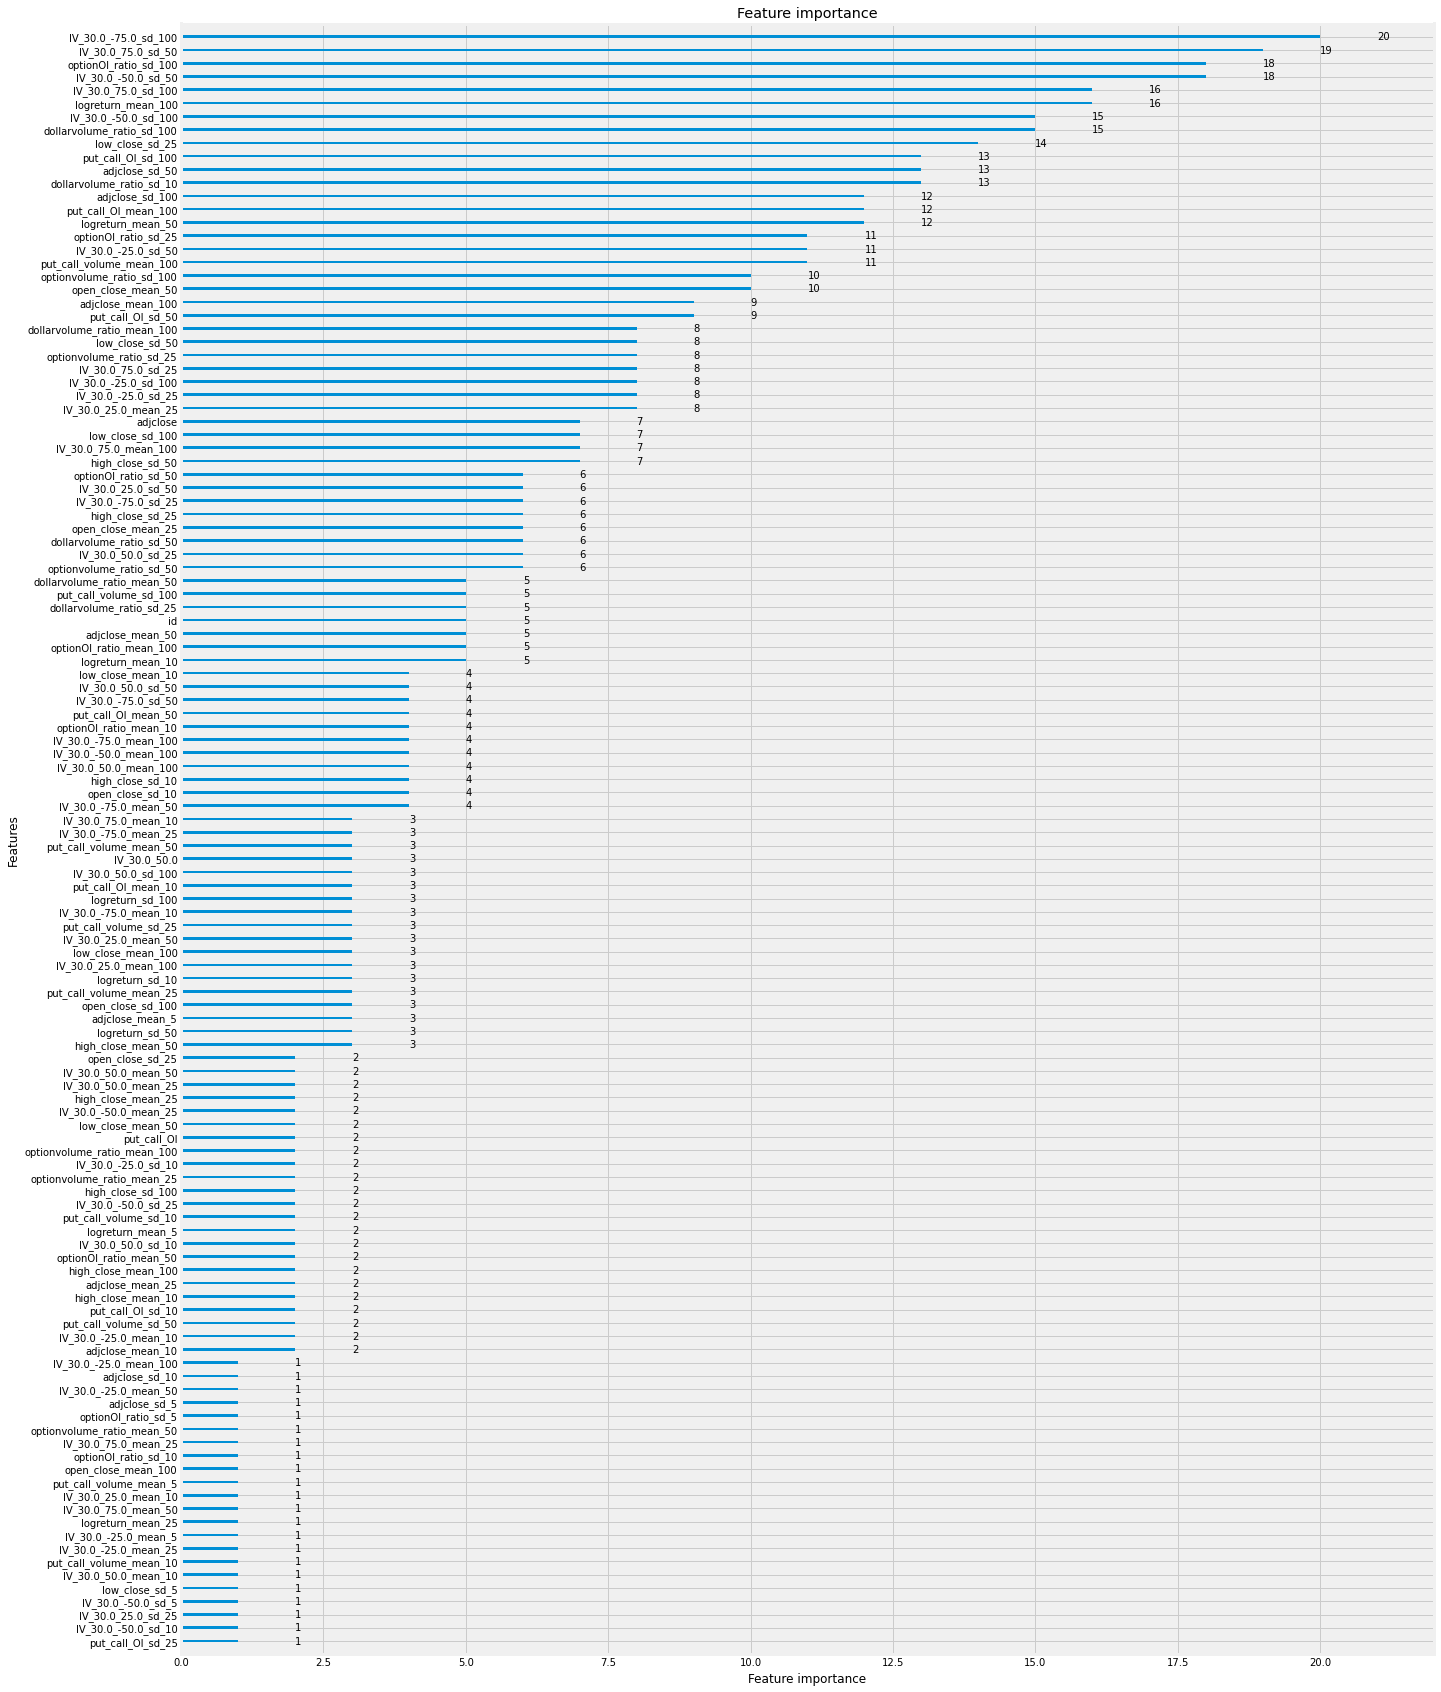

In [ ]:
fig, ax = plt.subplots(figsize=(20, 30))
lgb.plot_importance(bst , ax = ax)

# Generate Test Predictions

In [ ]:
sub_path = "drive/MyDrive/Algothon2021/algothon2021-0.0.6/src/algothon2021prediction/algothoncsv"

dfs = {}

for x in ["validate", "test"]:
  dfs[x] = pd.DataFrame()
  # for each asset, make prediction
  for i in range(46):
    temp_df = pd.read_csv(f"{sub_path}/Asset_{i}_{x}.csv")
    try:
      # dfs[x] = pd.concat([dfs[x], pd.DataFrame(model.predict(temp_df, batch_size=params["BATCH_SIZE"]))], axis = 0)
      dfs[x] = pd.concat([dfs[x], pd.DataFrame(bst.predict(temp_df))], axis = 0)
    except:
      pass

assert dfs["validate"].shape[0] == 21252
assert dfs["test"].shape[0] == 27881

dfs["validate"].to_csv("drive/My Drive/Algothon2021/TeamTBA_validation_prediction.csv", index=False)
dfs["test"].to_csv("drive/My Drive/Algothon2021/TeamTBA_test_prediction.csv",index=False)

# Public Leaderboard

+  -0.001831 - not sure which submission this is. Sanjits?